In [1]:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':'1-Hh3pdJlxhHWy42ZqXFDdjjBxe4vhoRg'})
downloaded.GetContentFile('train.csv') 

dowm1 = drive.CreateFile({'id':'1uJ9jU4cLMl9LQwKt_N4TsIgBn9RbOgTD'})
dowm1.GetContentFile('glove.twitter.27B.50d.txt') 

In [4]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

In [5]:
data = pd.read_csv('train.csv', encoding='utf-8')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

# Lematizing the words
lemmatizer = WordNetLemmatizer()

def lementization(text):
    text = lemmatizer.lemmatize(text)
    return text

data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: lementization(x.lower()))
data_without_tockenization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


LookupError: ignored

In [ ]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('word2vec_models_dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

cooking earlier got electrocuted crucial im psychic lol
[1413, 28, 358, 3, 82]


In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.twitter.27B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [ ]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           769850    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 770,371
Trainable params: 521
Non-trainable params: 769,850
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])


Epoch 1/50
686/686 [==============================] - 1s 2ms/step - loss: 0.6134 - accuracy: 0.6780 - precision: 0.6618 - recall: 0.5080 - val_loss: 0.5423 - val_accuracy: 0.7507 - val_precision: 0.7355 - val_recall: 0.6786
Epoch 2/50
686/686 [==============================] - 1s 1ms/step - loss: 0.5296 - accuracy: 0.7441 - precision: 0.7149 - recall: 0.6698 - val_loss: 0.5045 - val_accuracy: 0.7638 - val_precision: 0.7653 - val_recall: 0.6696
Epoch 3/50
686/686 [==============================] - 1s 1ms/step - loss: 0.5124 - accuracy: 0.7536 - precision: 0.7242 - recall: 0.6862 - val_loss: 0.4935 - val_accuracy: 0.7743 - val_precision: 0.7715 - val_recall: 0.6935
Epoch 4/50
686/686 [==============================] - 1s 1ms/step - loss: 0.5023 - accuracy: 0.7587 - precision: 0.7309 - recall: 0.6913 - val_loss: 0.4877 - val_accuracy: 0.7756 - val_precision: 0.7653 - val_recall: 0.7083
Epoch 5/50
686/686 [==============================] - 1s 2ms/step - loss: 0.4985 - accuracy: 0.7606 - pr

In [ ]:
glove_model = model.to_json()
with open('glove_mlp_model.json', 'w') as json_file:
    json_file.write(glove_model)

model.save_weights('glove_mlp_model.h5')

print('saved model!')

saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


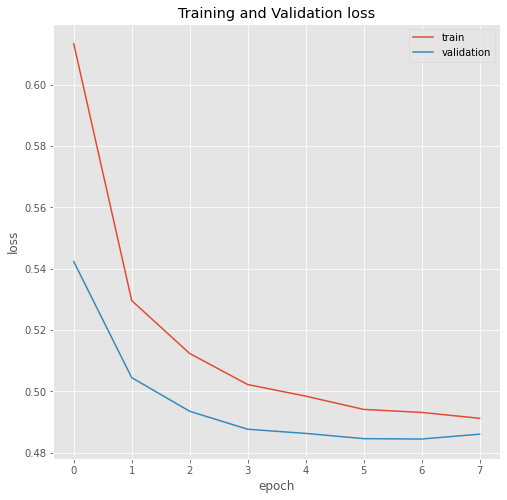

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(X_train, y_train, verbose=False)


[0.48769691586494446,
 0.7724419832229614,
 0.767912745475769,
 0.6718909740447998]

In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,368,58
Positive,106,230


In [ ]:
results

,Value
Accuracy,0.784777
Precision,0.798611
FPR,0.136150
Recall,0.684524
F1,0.737179


# Word2Vec

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
data2 = data_without_tockenization.copy()

In [ ]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [ ]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data2.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

tockenized_data.head()

tweet_data = tockenized_data['text']
tweet_data[1]

tweet_data_array = []

for arr in tweet_data:
    tweet_data_array.append(arr)

In [ ]:
# train word2vec model
model = Word2Vec(sentences=tweet_data_array, size=100, window=5, workers=3, min_count=1,
                 negative=20, iter=100,seed=1000,sg=0)
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))
    
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec100iterCBOW.txt'
model.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 16435


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# load embedding as a dict
def load_embedding(filename):
# load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [ ]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [ ]:

# load embedding from file
raw_embedding = load_embedding('embedding_word2vec100iterCBOW.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [ ]:
from keras import layers
# define model
model = Sequential()
model.add(embedding_layer)
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 1,540,721
Trainable params: 1,021
Non-trainable params: 1,539,700
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=16,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

Epoch 1/50
386/386 [==============================] - 1s 2ms/step - loss: 0.6171 - accuracy: 0.6618 - precision: 0.6134 - recall: 0.5614 - val_loss: 0.5965 - val_accuracy: 0.6866 - val_precision: 0.6219 - val_recall: 0.7467
Epoch 2/50
386/386 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.7281 - precision: 0.6887 - recall: 0.6625 - val_loss: 0.5627 - val_accuracy: 0.7099 - val_precision: 0.6699 - val_recall: 0.6809
Epoch 3/50
386/386 [==============================] - 1s 1ms/step - loss: 0.5295 - accuracy: 0.7424 - precision: 0.7057 - recall: 0.6800 - val_loss: 0.5544 - val_accuracy: 0.7259 - val_precision: 0.7101 - val_recall: 0.6447
Epoch 4/50
386/386 [==============================] - 1s 1ms/step - loss: 0.5228 - accuracy: 0.7489 - precision: 0.7170 - recall: 0.6800 - val_loss: 0.5559 - val_accuracy: 0.7259 - val_precision: 0.7180 - val_recall: 0.6283
Epoch 00004: early stopping


In [ ]:
model_w2vRNN = model.to_json()
with open('word2vec_MLP_model.json', 'w') as json_file:
    json_file.write(model_w2vRNN)

model.save_weights('word2vec_MLP_model.h5')

print('saved model!')

saved model!


In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,345,81
Positive,133,203


In [ ]:
results

,Value
Accuracy,0.719160
Precision,0.714789
FPR,0.190141
Recall,0.604167
F1,0.654839


# SimpleRNN+word2vec

In [ ]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [ ]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:

# load embedding from file
raw_embedding = load_embedding('embedding_word2vec100iterCBOW.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [ ]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.25))
model.add(SimpleRNN(128,return_sequences=True))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 23, 100)           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 23, 128)           29312     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,581,429
Trainable params: 41,729
Non-trainable params: 1,539,700
_______________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

Epoch 1/100
193/193 [==============================] - 3s 17ms/step - loss: 0.6688 - accuracy: 0.6449 - val_loss: 0.5659 - val_accuracy: 0.7376
Epoch 2/100
193/193 [==============================] - 3s 15ms/step - loss: 0.6121 - accuracy: 0.7007 - val_loss: 0.5500 - val_accuracy: 0.7362
Epoch 3/100
193/193 [==============================] - 3s 15ms/step - loss: 0.5917 - accuracy: 0.7194 - val_loss: 0.5595 - val_accuracy: 0.7478
Epoch 4/100
193/193 [==============================] - 3s 15ms/step - loss: 0.5747 - accuracy: 0.7382 - val_loss: 0.5585 - val_accuracy: 0.7405
Epoch 5/100
193/193 [==============================] - 3s 15ms/step - loss: 0.5710 - accuracy: 0.7351 - val_loss: 0.5628 - val_accuracy: 0.7420
Epoch 6/100
193/193 [==============================] - 3s 15ms/step - loss: 0.5516 - accuracy: 0.7492 - val_loss: 0.5485 - val_accuracy: 0.7376
Epoch 7/100
193/193 [==============================] - 3s 15ms/step - loss: 0.5283 - accuracy: 0.7627 - val_loss: 0.5442 - val_accuracy:

In [ ]:
model_w2vRNN = model.to_json()
with open('word2vec_RNN_model.json', 'w') as json_file:
    json_file.write(model_w2vRNN)

model.save_weights('word2vec_RNN_model.h5')

print('saved model!')

saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


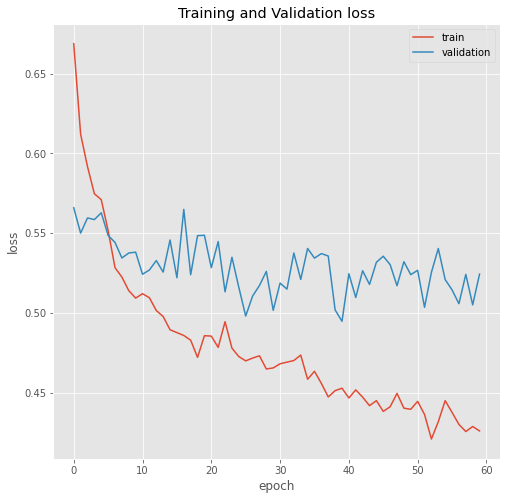

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,367,59
Positive,129,207


In [ ]:
results

,Value
Accuracy,0.753281
Precision,0.778195
FPR,0.138498
Recall,0.616071
F1,0.687708


## Word2vec+LSTM

In [ ]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.25))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 23, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 128)           117248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 1,706,421
Trainable params: 166,721
Non-trainable params: 1,539,700
______________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=64,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

Epoch 1/50
97/97 [==============================] - 8s 81ms/step - loss: 0.5367 - accuracy: 0.7497 - val_loss: 0.4909 - val_accuracy: 0.7653
Epoch 2/50
97/97 [==============================] - 7s 74ms/step - loss: 0.4779 - accuracy: 0.7864 - val_loss: 0.4821 - val_accuracy: 0.7784
Epoch 3/50
97/97 [==============================] - 7s 74ms/step - loss: 0.4463 - accuracy: 0.8011 - val_loss: 0.4788 - val_accuracy: 0.7784
Epoch 4/50
97/97 [==============================] - 7s 72ms/step - loss: 0.4300 - accuracy: 0.8127 - val_loss: 0.4740 - val_accuracy: 0.7872
Epoch 5/50
97/97 [==============================] - 7s 74ms/step - loss: 0.4214 - accuracy: 0.8131 - val_loss: 0.5246 - val_accuracy: 0.7799
Epoch 6/50
97/97 [==============================] - 7s 74ms/step - loss: 0.4080 - accuracy: 0.8250 - val_loss: 0.4648 - val_accuracy: 0.7959
Epoch 7/50
97/97 [==============================] - 7s 73ms/step - loss: 0.3880 - accuracy: 0.8363 - val_loss: 0.4799 - val_accuracy: 0.7813
Epoch 8/50
97

In [ ]:
model_w2vRNN = model.to_json()
with open('word2vec_LSTM_model.json', 'w') as json_file:
    json_file.write(model_w2vRNN)

model.save_weights('word2vec_LSTM_model.h5')

print('saved model!')

saved model!


In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,371,55
Positive,111,225


In [ ]:
results

,Value
Accuracy,0.782152
Precision,0.803571
FPR,0.129108
Recall,0.669643
F1,0.730519


## Word1Vec+Bidirectional LSTM

In [ ]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D,Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 23, 100)           1539700   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 23, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 23, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 1,938,677
Trainable params: 398,977
Non-trainable params: 1,539,700
_____________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=32,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)])

Epoch 1/50
193/193 [==============================] - 19s 100ms/step - loss: 0.5162 - accuracy: 0.7606 - val_loss: 0.4886 - val_accuracy: 0.7682
Epoch 2/50
193/193 [==============================] - 18s 92ms/step - loss: 0.4594 - accuracy: 0.7943 - val_loss: 0.4784 - val_accuracy: 0.7799
Epoch 3/50
193/193 [==============================] - 18s 93ms/step - loss: 0.4378 - accuracy: 0.8024 - val_loss: 0.4840 - val_accuracy: 0.7813
Epoch 4/50
193/193 [==============================] - 18s 93ms/step - loss: 0.4075 - accuracy: 0.8183 - val_loss: 0.4643 - val_accuracy: 0.7872
Epoch 5/50
193/193 [==============================] - 18s 93ms/step - loss: 0.3864 - accuracy: 0.8295 - val_loss: 0.4579 - val_accuracy: 0.7886
Epoch 6/50
193/193 [==============================] - 18s 93ms/step - loss: 0.3677 - accuracy: 0.8418 - val_loss: 0.4656 - val_accuracy: 0.7799
Epoch 7/50
193/193 [==============================] - 18s 94ms/step - loss: 0.3384 - accuracy: 0.8556 - val_loss: 0.4773 - val_accuracy

In [ ]:
model_w2vRNN = model.to_json()
with open('word2vec_BLSTM_model.json', 'w') as json_file:
    json_file.write(model_w2vRNN)

model.save_weights('word2vec_BLSTM_model.h5')

print('saved model!')

saved model!


In [ ]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

In [ ]:
results

,Value
Accuracy,0.782152
Precision,0.803571
FPR,0.129108
Recall,0.669643
F1,0.730519
